In [50]:
import math
import time
import random
from collections import deque
from collections import namedtuple
from dataclasses import dataclass

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F  #activation function https://pytorch.org/docs/stable/nn.functional.html

from torch.distributions.categorical import Categorical

from torch.profiler import profile, record_function, ProfilerActivity

import gym
import rl_gym

import matplotlib.pyplot as plt

from tqdm import tqdm
import gc

In [51]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

print('Using device:', device)
#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    

Using device: cpu


In [52]:

#calculate the scalar products of a batch of vectors
#https://stackoverflow.com/questions/65330884/efficiently-find-the-dot-product-of-two-lists-of-vectors-stored-as-pytorch-tenso
#[a[0]@b[0].T, a[1]@b[1].T, ...]
def bd(a,b):
    batch_size = a.shape[0]
    vector_len = a.shape[1]
    a1 = a.reshape(batch_size, 1, vector_len)
    b1 = b.reshape(batch_size, vector_len, 1)
    return torch.matmul(a1,b1).squeeze(1)

#a = torch.tensor([[1,2,3],[4,5,6]])
#b = torch.tensor([[7,8,9],[10,11,12]])
#bd(a,b)

In [78]:
#--------------------------------
class SimpleMLP(nn.Module):

    def __init__(self, num_observations, num_actions, num_neurons):
        super(SimpleMLP, self).__init__()
        
        self.layer1 = nn.Linear(num_observations, num_neurons)
        self.layer2 = nn.Linear(num_neurons, num_neurons)
        self.layer3 = nn.Linear(num_neurons, num_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

#--------------------------------
#--------------------------------

Transition = namedtuple('Transition', ('obs', 'action', 'reward', 'done', 'next_obs', 'entropy'))

class ReplayMemory():
    
    def __init__(self, memory_size):
        self.memory = deque([], maxlen=memory_size)
    
    def append(self, transition: Transition):
        self.memory.append(transition)
        
    def sample(self, batch_size):
        transitions = random.sample(self.memory, batch_size)
        return Transition(*zip(*transitions))        #see https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html for the *zip* trick
    
    def __len__(self):
        return len(self.memory)
    
#--------------------------------
#--------------------------------

TrainingRecord = namedtuple('Training', 
                            ('t', 'episode', 'episode_t', 'epsilon', 'score', 'loss_mean', 'loss_std', 'alpha_mean', 'alpha_std'))

@dataclass
class RLDQNParams:
    num_neurons: int = 32              #number of neurons in the simple MLP used to compute Q values
    max_episode_length: int = 600      #maximum length of an episode
    max_time_steps: int = 1000*600     #number of time steps used for training the model
    train_period: int = 1              #train the policy network every x timesteps
    learning_rate: float = 0.0001      #learning rate for the AdamW optimizer
    memory_size: int = 50_000          #size of replay memory, older samples are discarded
    memory_batch: int = 64             #size of batch sampled from replay memory for each training step
    gamma: float = 0.9                 #discount factor
    epsilon: float = 0.5               #initial epsilon value for the epsilon-greedy policy
    epsilon_min: float = 0.05          #minimum epsilon value for the epsilon-greedy strategy
    epsilon_half_life: int = 200       #decrease epsilon at every time step with the given half life
    target_update_rate: float = 0.05   #rate at which the target model is updated from the policy model
    log_recent_episodes: int = 100     #print a message every x episodes during training loop
    do_sdqn: bool = False              #Soft-DQN instead of greedy
    alpha: float = 0.98                #target temperature
    beta: float = 0.5                  #entropy penalty coeff
    evaluate_freq = 5                  #evaluate the model every x episodes
    
class RLDQN():
    def __init__(self, env: gym.Env, params: RLDQNParams, device):
        
        #get input parameters
        self.params = params
        self.num_observations = env.observation_space.shape[0]
        self.num_actions = env.action_space.n
        self.device = device

        self.model = SimpleMLP(num_observations = self.num_observations, num_actions=self.num_actions, num_neurons=self.params.num_neurons).to(self.device)
        self.target_model = SimpleMLP(num_observations = self.num_observations, num_actions=self.num_actions, num_neurons=self.params.num_neurons).to(self.device)
        self.target_model.load_state_dict(self.model.state_dict())
        

    def play(self, env):
        obs = env.reset()
        done=False
        while not done:
            env.render()
            obs = torch.tensor(obs, dtype=torch.float32, device=self.device).unsqueeze(0) 
            action, entropy = self.select_action(env, obs, epsilon=0., do_sdqn=False) #do_sdqn=self.params.do_sdqn)
            obs, reward, done, info = env.step(action.item())        
        env.close()
        
    def evaluate(self, env, num_episodes=100, episode_length=600):
        scores=[]
        for e in range(num_episodes):
            obs = env.reset()
            score=0
            done=False
            episode_t=0
            while not done:
                obs = torch.tensor(obs, dtype=torch.float32, device=self.device).unsqueeze(0) #https://pytorch.org/docs/stable/generated/torch.unsqueeze.html
                action, entropy = self.select_action(env, obs, epsilon=0., do_sdqn=False) #do_sdqn=self.params.do_sdqn)
                obs, reward, done, info = env.step(action.item())
                score += reward
                episode_t +=1
                if episode_t>episode_length: #force episode termination
                    done=True
            scores.append(score)
        mean_reward = np.mean(scores)
        std_reward = np.std(scores)
        return mean_reward, std_reward, scores

    def train(self, env, params):
        
        self.params = params
        print("start training with params:")
        print(params)
        
        finished_training = False
        epsilon = self.params.epsilon
        optimizer = optim.AdamW(self.model.parameters(), lr=self.params.learning_rate, amsgrad=True) #https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html
        criterion = nn.SmoothL1Loss() #https://pytorch.org/docs/stable/generated/torch.nn.SmoothL1Loss.html

        self.memory = ReplayMemory(self.params.memory_size)
        self.training_record = [] #array of TrainingRecord namedtuples to record progress during the training loop; one entry per episode
        self.eval_record = [] #array of TrainingRecord to track evaluation results during the training loop
        
        self.target_entropy = -np.log((1./self.num_actions))*0.98
        self.alpha = torch.ones(1, requires_grad=True, dtype=torch.float32, device=self.device)
        self.alpha_optimizer = optim.Adam([self.alpha], lr=self.params.learning_rate, eps=1e-4)

        
        obs = env.reset()
        obs = torch.tensor(obs, dtype=torch.float32, device=self.device).unsqueeze(0) #https://pytorch.org/docs/stable/generated/torch.unsqueeze.html
        
        t = 0 #to measure time since beginning of training
        episode = 0 #to measure number of episodes
        episode_t = 0 #to measure length of current episode
        score = 0. #to track score of current episode
        loss_record = [] #track loss during episode
        alpha_record = [] #track alpha during episode
        evaluate_episode = False #track whether this episode is for training or evaluation

        #training loop
        #environment is reset within the loop whenever it reaches a terminal step or when it reaches the max lenghth of an episode
        #tqdm_bar = tqdm(range(self.params.max_time_steps))
        while not finished_training:
           
            #generate the next transition and add it to replay memory
            
            if evaluate_episode:
                action, entropy = self.select_action(env, obs, epsilon=0., do_sdqn=False) #greedy
            else:
                action, entropy = self.select_action(env, obs, epsilon, self.params.do_sdqn) #epsilong-greedy or softmax
                
            next_obs, reward, done, info = env.step(action.item())

            score += reward #episode's score
            #obs is already a tensor on device
            #action is already a tensor on device, see select_action()
            next_obs = torch.tensor(next_obs, dtype=torch.float32, device=self.device).unsqueeze(0) #https://pytorch.org/docs/stable/generated/torch.unsqueeze.html
            reward = torch.tensor([reward], dtype=torch.float32, device=self.device)
            not_done = torch.tensor([0. if done else 1.], dtype=torch.float32, device=self.device)  #flip done to more easily calculate td_targets during training (see below)
            entropy = torch.tensor([entropy], dtype=torch.float32, device=self.device)
            self.memory.append(Transition(obs, action, reward, not_done, next_obs, entropy))

            #train the model

            if not evaluate_episode and len(self.memory) > self.params.memory_batch and t % self.params.train_period == 0:

                batch = self.memory.sample(self.params.memory_batch)

                #calculate the current model's estimate of the Q value corresponding to the observation and action taken at the time
                #Q = model[obs][action]
                q = self.model(torch.cat(batch.obs)).gather(1, torch.cat(batch.action)).squeeze(1) 

                #calculate the temporal difference's target value, which is the reward + the discounted Q value of the following state
                #use the 'target' model for stability, the target model evolves more slowly than the policy model
                #non_terminal is 0 if the transition was terminal, 1 otherwise (this is the flip of the 'done' value returned by the env
                #TD Target = reward + non_terminal * gamma * max_action[model(next_obs)]
                with torch.no_grad():

                    next_q_values = self.target_model(torch.cat(batch.next_obs)) #calculate the Q values on the resulting state of the transition

                    if self.params.do_sdqn:
                        p = torch.nn.functional.softmax(next_q_values, dim=1) #probabilities of actions for each sample of the batch
                        log_p = torch.nn.functional.log_softmax(next_q_values, dim=1) #their logs
                        td_targets = bd(p, next_q_values - self.alpha*log_p)  #bd is batch of dot product, see function def above
                        td_targets = torch.flatten(td_targets)
                        td_targets -= 0.5*self.params.beta*(torch.cat(batch.entropy)-entropy)**2 #entropy penalty, see https://deepai.org/publication/revisiting-discrete-soft-actor-critic
                        
                    else:
                        td_targets = next_q_values.max(1).values #get the max Q value across possible actions
                        
                    td_targets *= torch.cat(batch.done) #keep target Q value estimate only for non-terminal transition .done is 0 is we reached the terminal state at this transition, 1 otherwise (see how the done flag is inverted when recording it in replay memory
                    td_targets *= self.params.gamma #discount
                    td_targets += torch.cat(batch.reward) #add reward for both terminal and non-terminal transitions
                    

                #calculate the temporal difference loss
                #the criterion function returns the average loss over the transitions sampled in this batch
                #the loss function is the square of the error is the error is less than one, or the abs value of the error otherwise
                #this is more robust to outliers than pure squared error
                #td_loss = mean_batch[(td_targets-q)^2]
                td_loss = criterion(td_targets, q)
                loss_record.append(td_loss.item())

                #update the model's parameters to minimize td loss by stochastic gradient descent
                optimizer.zero_grad()
                td_loss.backward()
                torch.nn.utils.clip_grad_value_(self.model.parameters(),100) #https://pytorch.org/docs/stable/generated/torch.nn.utils.clip_grad_value_.html
                optimizer.step()

                #update temperature
                #if self.params.do_sdqn:
                #    alpha_loss = bd(p, - self.alpha*((self.target_entropy + log_p).detach())).mean()
                #    self.alpha_optimizer.zero_grad()
                #    alpha_loss.backward()
                #    self.alpha_optimizer.step()
                #    alpha_record.append(self.alpha.item())
                
                #update the parameters theta' of the target model from the policy model
                #theta' <- update_rate*theta + (1-update_rate)*theta'
                with torch.no_grad():
                    target_params = self.target_model.state_dict() #https://pytorch.org/tutorials/recipes/recipes/what_is_state_dict.html
                    policy_params = self.model.state_dict()
                    for key in policy_params:
                        target_params[key] = policy_params[key]*self.params.target_update_rate + target_params[key]*(1. - self.params.target_update_rate)
                    self.target_model.load_state_dict(target_params)


            episode_t += 1
            if done or episode_t>self.params.max_episode_length: 

                #end of episode, prepare next one

                if epsilon > self.params.epsilon_min:
                    epsilon -= epsilon * math.log(2)/self.params.epsilon_half_life
                
                #log temporary results
                loss_mean = np.mean(loss_record)
                loss_std = np.std(loss_record)
                loss_record=[]
                alpha_mean = np.mean(alpha_record)
                alpha_std = np.std(alpha_record)
                alpha_record=[]
                r = TrainingRecord(t=t, episode=episode, episode_t=episode_t, epsilon=epsilon, score=score, loss_mean=loss_mean, loss_std=loss_std, alpha_mean=alpha_mean, alpha_std=alpha_std)
                if evaluate_episode:
                    self.eval_record.append(r)
                else:
                    self.training_record.append(r)
                
                if evaluate_episode: #episode % self.params.log_recent_episodes==0:
                    print(r)

                #start a new episode
                #tqdm_bar.set_postfix({'episode': episode})
                
                episode += 1
                
                episode_t = 0
                score = 0.
                next_obs = env.reset()
                next_obs = torch.tensor(next_obs, dtype=torch.float32, device=device).unsqueeze(0) 

                evaluate_episode = (episode % self.params.evaluate_freq==0)

            #prepare next iteration
            
            obs = next_obs

            t += 1
            if t>self.params.max_time_steps:
                finished_training=True  #will exit the main training loop

        

    def select_action(self, env, obs, epsilon, do_sdqn):
        if do_sdqn:
            #Q-model for this state gives us logits of the policy 
            #Run it through softmax to obtain the proba and use a Categorical distribution
            with torch.no_grad():
                q_values = self.model(obs) 
                policy = Categorical(logits=q_values)
                action = policy.sample() #sample it
                return action.view(1,1), policy.entropy().item()
        else:
            #use an epsilon-greedy strategy
            if random.random()<epsilon:
                action = env.action_space.sample()
                return torch.tensor([[action]], device=self.device, dtype=torch.long), 0
            else:
                with torch.no_grad():
                    q_values = self.model(obs)
                    max_q = q_values.max(1).indices
                    return max_q.view(1,1), 0

            
            
            

In [79]:
env = gym.make("rl_gym/PuckWorld-v0", fps=60)

params = RLDQNParams()
'''
    num_neurons: int = 32              #number of neurons in the simple MLP used to compute Q values
    max_episode_length: int = 600      #maximum length of an episode
    max_time_steps: int = 1000*600     #number of time steps used for training the model
    train_period: int = 1              #train the policy network every x timesteps
    learning_rate: float = 0.0001      #learning rate for the AdamW optimizer
    memory_size: int = 50_000          #size of replay memory, older samples are discarded
    memory_batch: int = 64             #size of batch sampled from replay memory for each training step
    gamma: float = 0.9                 #discount factor
    epsilon: float = 0.5               #initial epsilon value for the epsilon-greedy policy
    epsilon_min: float = 0.05          #minimum epsilon value for the epsilon-greedy strategy
    epsilon_half_life: int = 200       #decrease epsilon at every time step with the given half life
    target_update_rate: float = 0.05   #rate at which the target model is updated from the policy model
    log_recent_episodes: int = 100     #print a message every x episodes during training loop
    do_sdqn: bool = False              #Soft-DQN instead of greedy
'''

params.num_neurons = 128
params.max_time_steps: int = 300*600      #number of time steps used for training the model

print(device)

dqn = RLDQN(env, params, device)

#start_time = time.time()
#mean_reward, std_reward, scores = dqn.evaluate(env, num_episodes=100, episode_length=600)
#print("--- %s seconds ---" % (time.time() - start_time))
#print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")
#print(scores)

cpu


train DQN
start training with params:
RLDQNParams(num_neurons=128, max_episode_length=600, max_time_steps=180000, train_period=1, learning_rate=0.0001, memory_size=50000, memory_batch=64, gamma=0.9, epsilon=0.5, epsilon_min=0.05, epsilon_half_life=200, target_update_rate=0.05, log_recent_episodes=100, do_sdqn=False, alpha=0.98, beta=0.5)


C:\Users\remyh\anaconda3\envs\tfgpu\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\remyh\anaconda3\envs\tfgpu\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\remyh\anaconda3\envs\tfgpu\lib\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\remyh\anaconda3\envs\tfgpu\lib\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\remyh\anaconda3\envs\tfgpu\lib\site-packages\numpy\core\_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training(t=600, episode=0, episode_t=601, epsilon=0.4982671320486001, score=-583.9244412245401, loss_mean=0.10447133344631067, loss_std=0.06165982173748925, alpha_mean=nan, alpha_std=nan)
Training(t=60700, episode=100, episode_t=601, epsilon=0.35211604521632495, score=-182.85007489792767, loss_mean=0.032463495932812315, loss_std=0.040773486462055634, alpha_mean=nan, alpha_std=nan)
Training(t=120800, episode=200, episode_t=601, epsilon=0.2488338108697318, score=-131.4085579719353, loss_mean=0.03760938174561977, loss_std=0.04652855296453419, alpha_mean=nan, alpha_std=nan)
--- 15.06436583995819 minutes ---
evaluate DQN
--- 16.000237464904785 seconds ---
mean_reward:-163.13 +/- 116.69


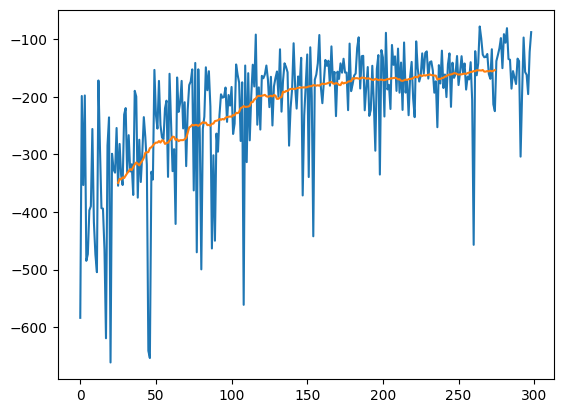

In [36]:
print('train DQN')
start_time = time.time()
dqn.train(env, params)
print("--- %s minutes ---" % ((time.time() - start_time)/60))

print('evaluate DQN')
start_time = time.time()
mean_reward, std_reward, scores = dqn.evaluate(env, num_episodes=100, episode_length=600)
print("--- %s seconds ---" % (time.time() - start_time))
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

log_dqn = TrainingRecord(*zip(*dqn.training_record))

y1 = np.array(log_dqn.score)

window=50
y_runningmean1 = np.convolve(y1, np.ones(window)/window, mode='valid')
plt.plot(y1, label='dqn')
plt.plot(range(int(window/2),len(y1)-int(window/2)+1),y_runningmean1, label='dqn')




train SDQN
start training with params:
RLDQNParams(num_neurons=128, max_episode_length=600, max_time_steps=180000, train_period=1, learning_rate=0.0001, memory_size=50000, memory_batch=64, gamma=0.9, epsilon=0.5, epsilon_min=0.05, epsilon_half_life=200, target_update_rate=0.05, log_recent_episodes=100, do_sdqn=True, alpha=0.98, beta=0.5)
Training(t=3605, episode=5, episode_t=601, epsilon=0.48969246203143585, score=-749.8498334468335, loss_mean=nan, loss_std=nan, alpha_mean=nan, alpha_std=nan)
Training(t=6610, episode=10, episode_t=601, epsilon=0.4812653533547135, score=-358.29699941408495, loss_mean=nan, loss_std=nan, alpha_mean=nan, alpha_std=nan)
Training(t=9615, episode=15, episode_t=601, epsilon=0.472983266638008, score=-345.6029653505442, loss_mean=nan, loss_std=nan, alpha_mean=nan, alpha_std=nan)
Training(t=12620, episode=20, episode_t=601, epsilon=0.46484370620104587, score=-330.5293387890972, loss_mean=nan, loss_std=nan, alpha_mean=nan, alpha_std=nan)
Training(t=15625, episode=

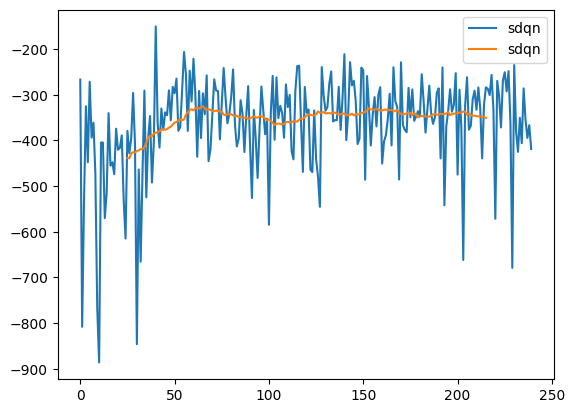

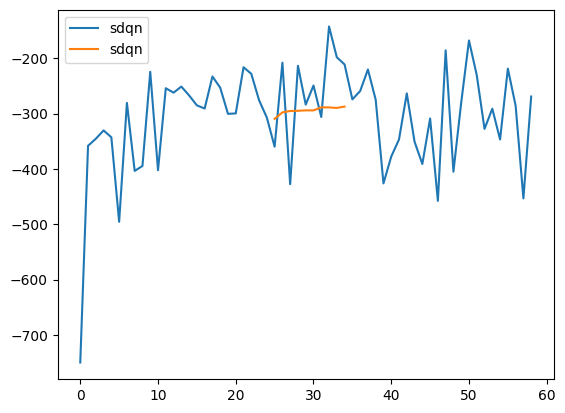

In [80]:

params.do_sdqn = True

sdqn = RLDQN(env, params, device)

print('train SDQN')
start_time = time.time()
sdqn.train(env, params)
print("--- %s minutes ---" % ((time.time() - start_time)/60))

print('evaluate SDQN')
start_time = time.time()
mean_reward, std_reward, scores = sdqn.evaluate(env, num_episodes=100, episode_length=600)
print("--- %s seconds ---" % (time.time() - start_time))
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

log_sdqn = TrainingRecord(*zip(*sdqn.training_record))

#y = np.array(log.loss_mean)
#y = np.array(log.loss_std)
#y1 = np.array(log_dqn.score)
y2 = np.array(log_sdqn.score)
#y = np.array(log.epsilon)

#window=50
#y_runningmean1 = np.convolve(y1, np.ones(window)/window, mode='valid')
#plt.plot(y1, label='dqn')
#plt.plot(range(int(window/2),len(y1)-int(window/2)+1),y_runningmean1, label='dqn')

y_runningmean2 = np.convolve(y2, np.ones(window)/window, mode='valid')
plt.plot(y2, label='sdqn')
plt.plot(range(int(window/2),len(y2)-int(window/2)+1),y_runningmean2, label='sdqn')

plt.legend()
plt.show()

log_sdqn = TrainingRecord(*zip(*sdqn.eval_record))

#y = np.array(log.loss_mean)
#y = np.array(log.loss_std)
#y1 = np.array(log_dqn.score)
y2 = np.array(log_sdqn.score)
#y = np.array(log.epsilon)

#window=50
#y_runningmean1 = np.convolve(y1, np.ones(window)/window, mode='valid')
#plt.plot(y1, label='dqn')
#plt.plot(range(int(window/2),len(y1)-int(window/2)+1),y_runningmean1, label='dqn')

y_runningmean2 = np.convolve(y2, np.ones(window)/window, mode='valid')
plt.plot(y2, label='sdqn')
plt.plot(range(int(window/2),len(y2)-int(window/2)+1),y_runningmean2, label='sdqn')

plt.legend()

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

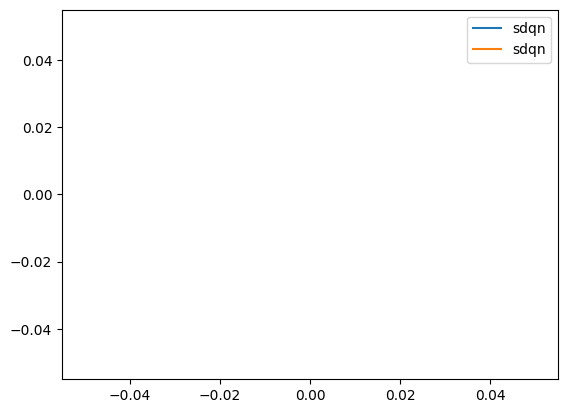

In [86]:
sdqn_training = TrainingRecord(*zip(*sdqn.training_record))

y2 = np.array(sdqn_training.alpha_mean)

y_runningmean2 = np.convolve(y2, np.ones(window)/window, mode='valid')
plt.plot(y2, label='sdqn')
plt.plot(range(int(window/2),len(y2)-int(window/2)+1),y_runningmean2, label='sdqn')

plt.legend()
y2


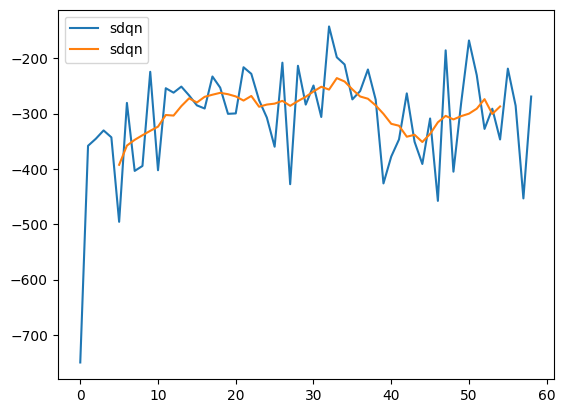

In [84]:
sdqn_training = TrainingRecord(*zip(*sdqn.training_record))
sdqn_eval = TrainingRecord(*zip(*sdqn.eval_record))

y2 = np.array(sdqn_eval.score)

window=10

y_runningmean2 = np.convolve(y2, np.ones(window)/window, mode='valid')
plt.plot(y2, label='sdqn')
plt.plot(range(int(window/2),len(y2)-int(window/2)+1),y_runningmean2, label='sdqn')

plt.legend()
plt.show()

